<h1 align=center>AUC analysis</h1>

**This notebook is used for AUC analysis**

### import and function method

In [17]:
import torch, sys
sys.path.append('../')
import constants
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
from pathlib import Path

In [32]:
def plot_roc_curve(y_true, y_pred_proba, title='Receiver Operating Characteristic (ROC) Curve', 
                  other = None, labels = None, save = None, box = False, plot=True):
    """
    绘制 ROC 曲线
    参数：
    - y_true: 实际标签
    - y_pred_proba: 预测概率
    - title: 图表标题
    - other: dict {configuration: ((label, predict))}

    返回：
    无，直接显示 ROC 曲线图表
    """
    roc_auc1 = 0
    roc_auc2 = 0
    # 计算 ROC 曲线的真正例率（tpr）、假正例率（fpr）以及 AUC
    plt.figure(figsize=(4, 4))
    plt.ylim(0,1)
    if other is not None:
      for config, values in other.items():
        label = values[0]
        predict = values[1] 
        fpr, tpr, thresholds = roc_curve(label, predict)
        roc_auc = auc(fpr, tpr)
        if plot:
          plt.plot(fpr, tpr, lw=2, label= config + ' (AUC = {:.2f})'.format(roc_auc))
    roc_auc1 = roc_auc

    fpr, tpr, thresholds = roc_curve(y_true, list(y_pred_proba))
    roc_auc = auc(fpr, tpr)
    roc_auc2 = roc_auc
    # print(title, roc_auc)

    # 绘制 ROC 曲线
    if box:
        text = plt.text(x=0.02,#文本x轴坐标 
          y=0.948, #文本y轴坐标
          s=title, #文本内容
          fontdict=dict(fontsize=20, color='r',family='monospace',),#字体属性字典
          #添加文字背景色
          bbox={'facecolor': '#F0C284', #填充色
                 'edgecolor':'b',#外框色
                'alpha': 0.5, #框透明度
                'pad': 8,#本文与框周围距离 
                },
          color = "#992224"
          )
    else:
          plt.title(title)
      # text_box_props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
      # plt.text(x=20, y=5, s=title, bbox=text_box_props, fontsize=12, color='darkblue', ha='center')

      # plt.text(x=6000, y=0.4, s=title, bbox=dict(facecolor='red', alpha=0.5))
    if labels is not None:
      if plot:
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=labels + ' (AUC = {:.2f})'.format(roc_auc))
    else:
      if plot:
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=' (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

    plt.legend(loc='lower right', fontsize='14')
    plt.grid(True)
    if save is not None:
      plt.savefig(f'{save}/{title}.png', format='png')
    return roc_auc1, roc_auc2
  

# 示例用法
# 假设 y_true 和 y_pred_proba 是你的标签和预测概率
# plot_roc_curve(y_true, y_pred_proba)


def print_roc( plot=True, record_roc = False, training_step = 0, 
               data = None, save = None, box = False):
  """
  for each label(disease) gets its own auc
  plot: bool, whether plot the roc plot in this function
  return auc value 
  """
  
  disease_auc = {}
  label_dis1 = None
  diff = []
  for i, disease in enumerate(constants.CHEXPERT_LABELS):
    # print(data.values)
    label_dis = list(data.values())[0]["labels"]
    label_dis =  label_dis[:, i]
    label_dis1 =  list(data.values())[1]["labels"]
    label_dis1 = label_dis1[:, i]
    predictions_tensor = list(data.values())[0]["predict"]
    predictions_tensor_1 = list(data.values())[1]["predict"]

    each_class_roc = {}

    for k, j in enumerate(constants.class_name):
      if j != "positive":
        continue

      pred_dis = predictions_tensor[:, i*len(constants.class_name) + k].cpu().numpy()
      pred_dis_1 = predictions_tensor_1[:, i*len(constants.class_name) + k].cpu().numpy()

      true_class = [1 if constants.class_name[j] == y else 0 for y in label_dis]
      true_class_1 = [1 if constants.class_name[j] == y else 0 for y in label_dis1]
      assert true_class == true_class_1
      if(len(set(true_class))==1):
        print(constants.RED, "this disease have something wrong: "+constants.RESET, disease, ", ", j, "in this case set auc is 0!!!")
        each_class_roc[j] = 0
        continue
      title = f"{disease}"
      item = list(data.keys())
      if predictions_tensor_1 is not None:
        other = {item[1]: (true_class_1, pred_dis_1)}
        roc_auc1, roc_auc2 = plot_roc_curve( true_class, pred_dis,plot = plot, title = title , other = other, labels = item[0],save = save, box = box)
      else:
        roc_auc1, roc_auc2 = plot_roc_curve( true_class, pred_dis,plot = plot, title = title, labels = item[0],save = save, box = box)
    #   each_class_roc[j] = roc_auc_score(true_class, pred_dis, multi_class="ovr", average="micro",)
    # disease_auc[disease] = each_class_roc
      diff.append(roc_auc1 - roc_auc2)
  plt.show()
  return roc_auc1, roc_auc2, diff

### load data

In [37]:
bio_high_task = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_False_False_task_balance\tensor.pth"
bio_high_task_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_False_False_task_balance_final\tensor.pth"
bio_high_no_contrastive_task = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_False_True_task_balance\tensor.pth"
bio_high_no_contrastive_task_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_False_True_task_balance_final\tensor.pth"
bio_high_no_ortho_task = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_True_False_task_balance\tensor.pth"
bio_high_no_ortho_task_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_binary_True_False_task_balance_final\tensor.pth"
bio_orth_task = r"..\output\dump_prediction_output\biomedclip_None_False_False_NA_False_False_task_balance\tensor.pth"
bio_orth_f = r"..\output\dump_prediction_output\biomedclip_None_False_False_NA_False_False_task_balance_final\tensor.pth"
bio_v = r"..\output\dump_prediction_output\biomedclip_None_True_False_NA_False_False_NA\tensor.pth"
bio_v_f = r"..\output\dump_prediction_output\biomedclip_None_True_False_NA_False_False_NA_final\tensor.pth"
bio_high_task = torch.load(bio_high_task, map_location=torch.device(device))
bio_high_task_f = torch.load(bio_high_task_f, map_location=torch.device(device))
bio_high_no_contrastive_task = torch.load(bio_high_no_contrastive_task, map_location=torch.device(device))
bio_high_no_contrastive_task_f = torch.load(bio_high_no_contrastive_task_f, map_location=torch.device(device))
bio_high_no_ortho_task = torch.load(bio_high_no_ortho_task, map_location=torch.device(device))
bio_high_no_ortho_task_f = torch.load(bio_high_no_ortho_task_f, map_location=torch.device(device))
bio_orth_task = torch.load(bio_orth_task, map_location=torch.device(device))
bio_orth_f = torch.load(bio_orth_f, map_location=torch.device(device))
bio_v = torch.load(bio_v, map_location=torch.device(device))
bio_v_f = torch.load(bio_v_f, map_location=torch.device(device))

### plot

##### different config with vision_only baseline

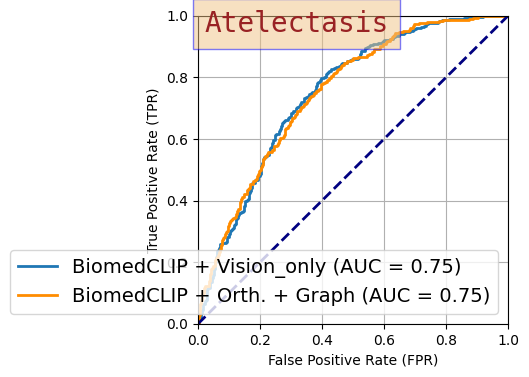

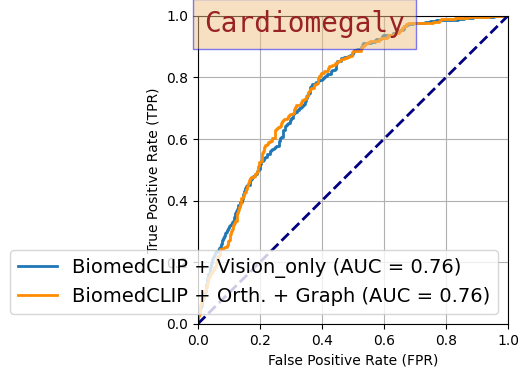

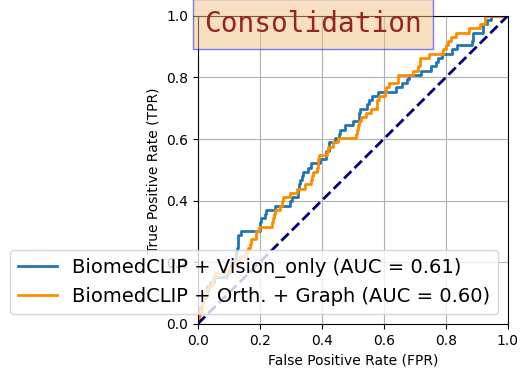

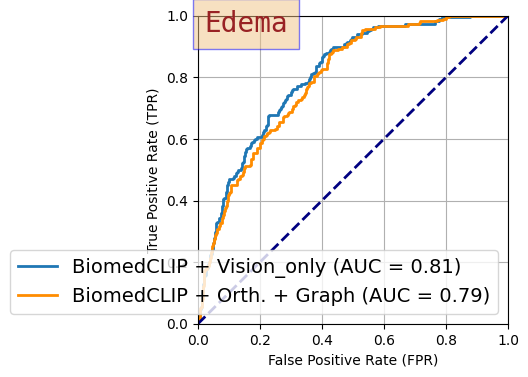

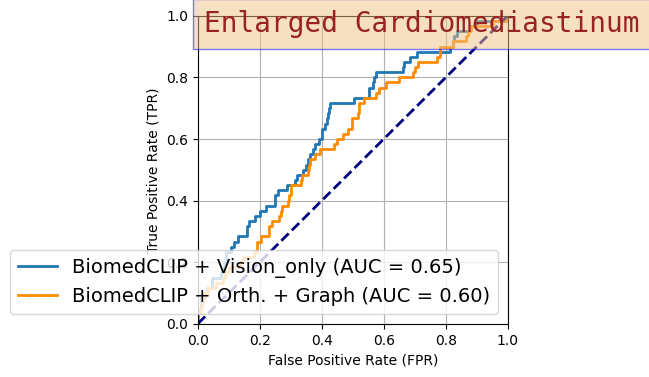

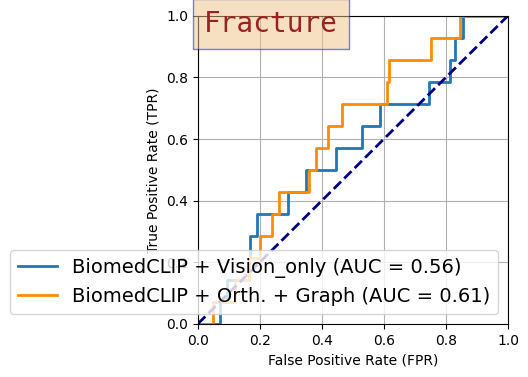

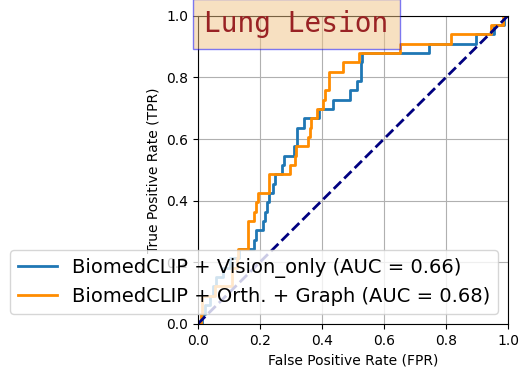

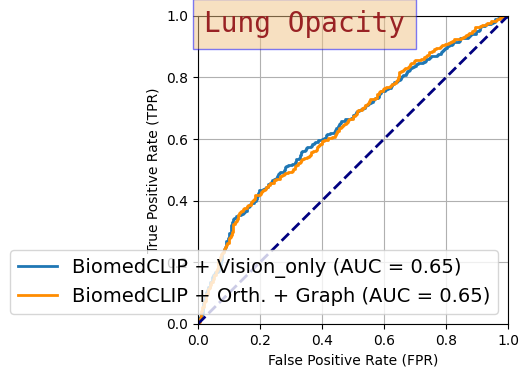

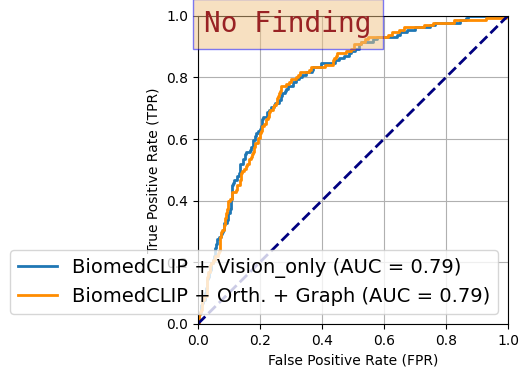

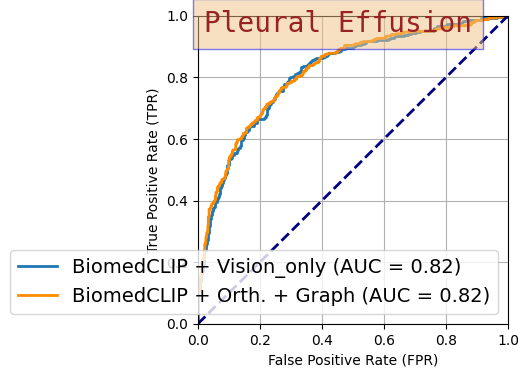

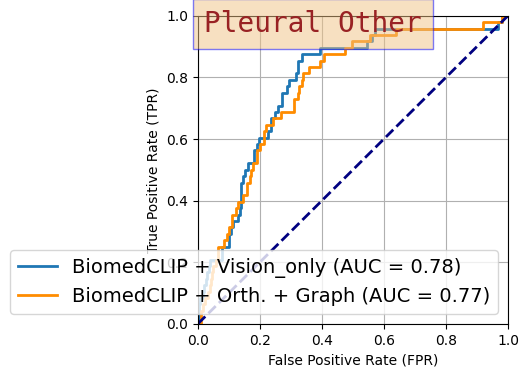

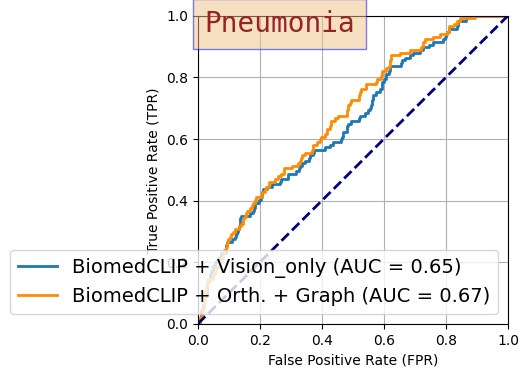

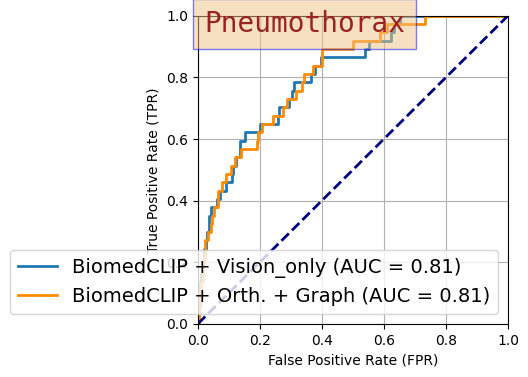

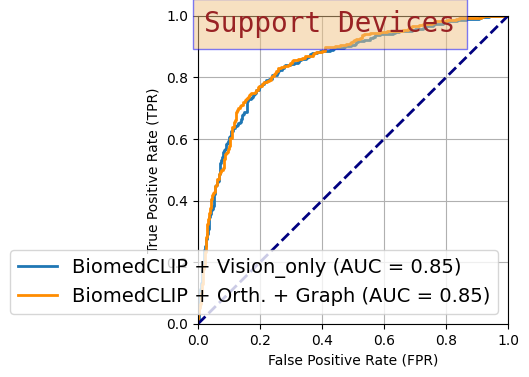

14
auc diff:  -0.01954963765733575
average diff:  -0.0013964026898096965


In [35]:
data = { "BiomedCLIP + Orth. + Graph":{'predict': bio_high_task["predictions"], 'labels':bio_high_task["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
_,_, diff = print_roc(
          data = data , box = True, plot=True)
print(len(diff))
print("auc diff: ", sum(diff)) #"the diff = sum(auc(BiomedCLIP + Vision_only)) - sum(auc(BiomedCLIP + Orth. + Graph))"
print("average diff: ", sum(diff)/len(diff))

<font type=Sylfaen color=#C3A060>using orth + graph can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055> orth + graph can improve the performance in the poor class in the original version only version<br>
(orth + graph) - vision_only = 1.9 </font><br>

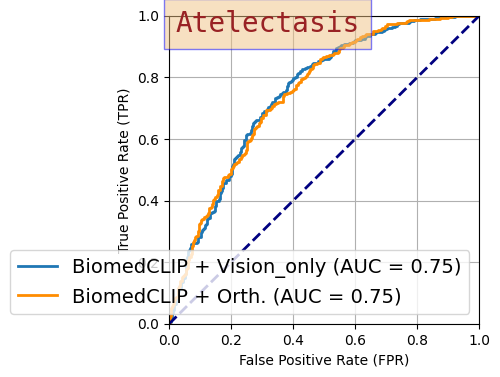

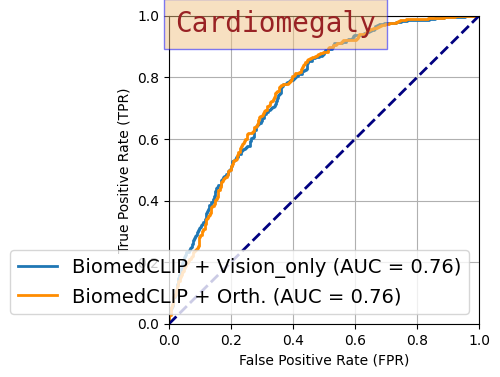

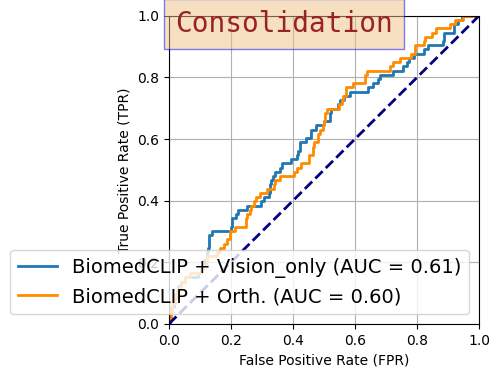

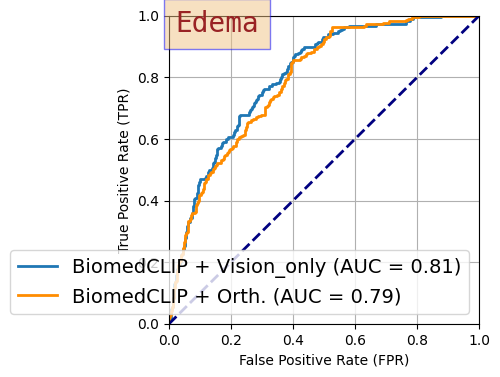

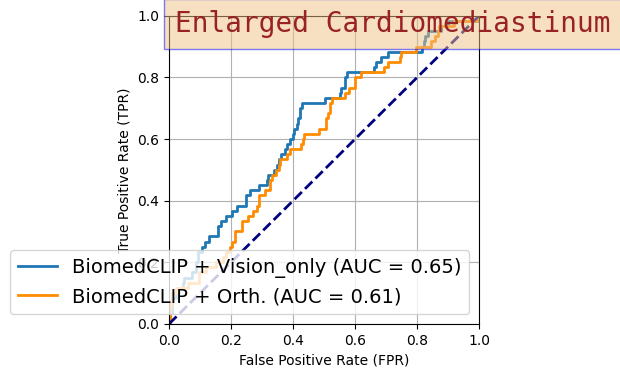

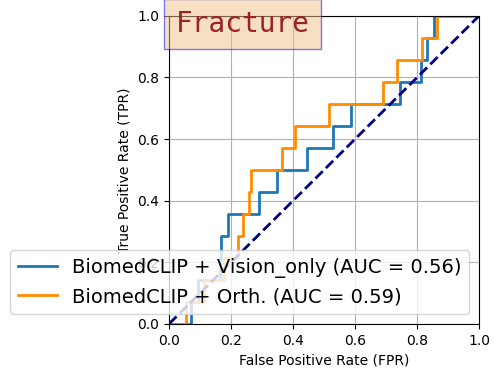

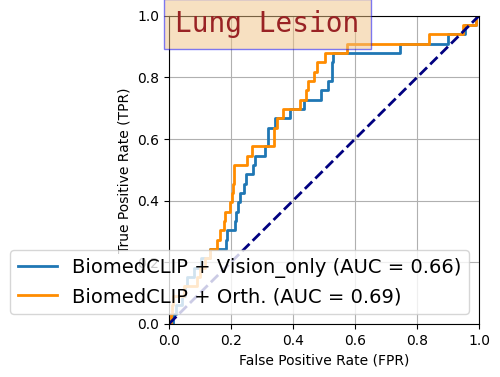

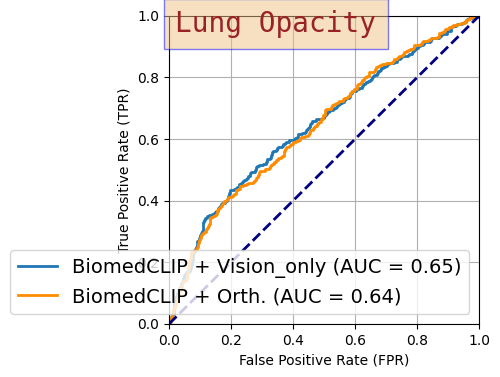

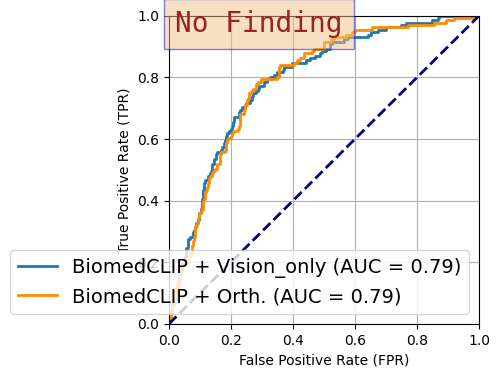

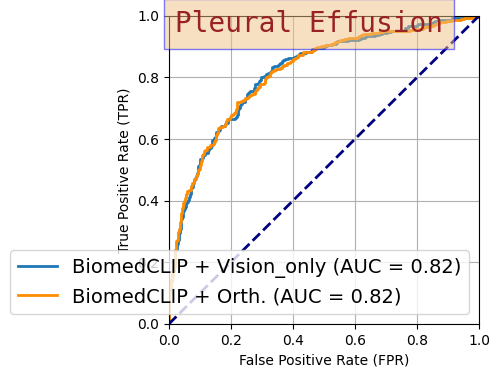

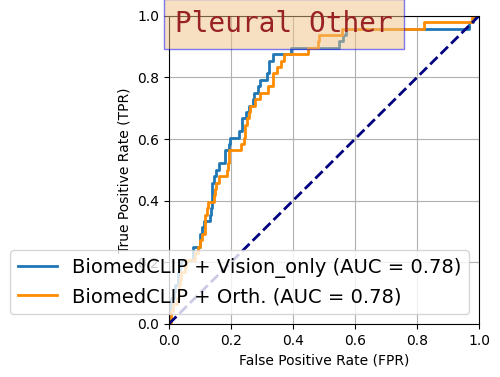

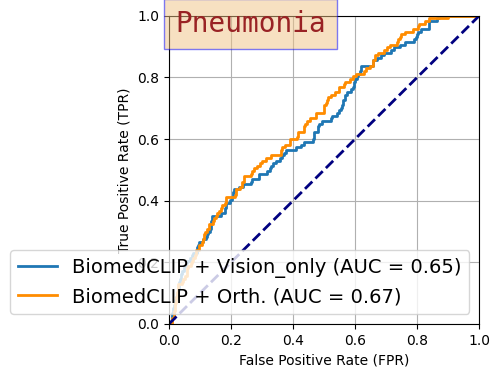

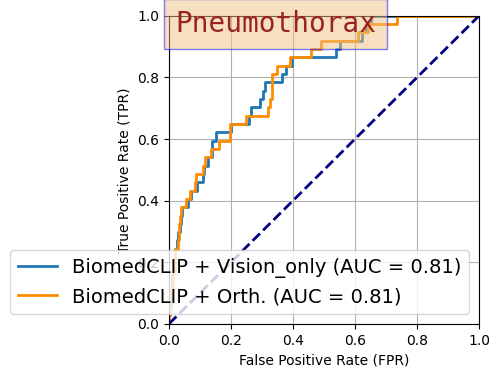

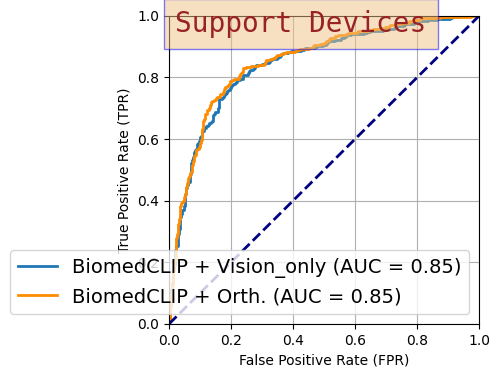

14
auc diff:  -0.009866260081900502
average diff:  -0.000704732862992893


In [46]:
data = { "BiomedCLIP + Orth.":{'predict': bio_orth_task["predictions"], 'labels':bio_orth_task["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
_,_, diff = print_roc(
          data = data , box = True, plot=True)
print(len(diff))
print("auc diff: ", sum(diff)) #"the diff = sum(auc(BiomedCLIP + Vision_only)) - sum(auc(BiomedCLIP + Orth. + Graph))"
print("average diff: ", sum(diff)/len(diff))

<font type=Sylfaen color=#C3A060>using orth can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055>
orth - vision_only = 0.9 </font><br>

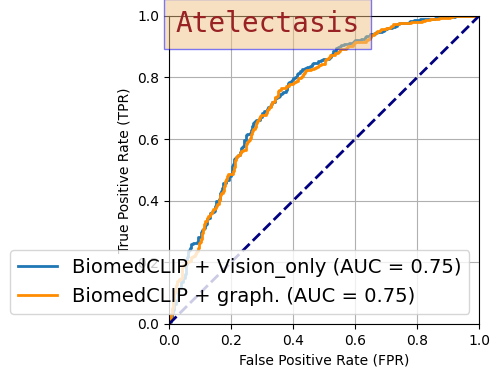

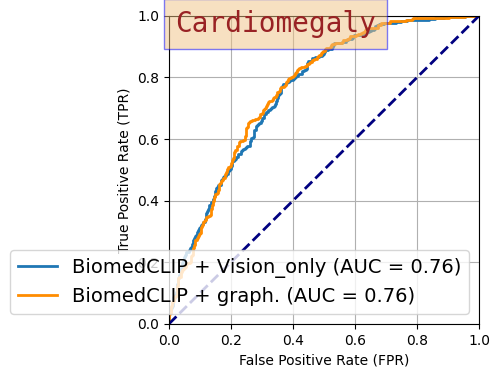

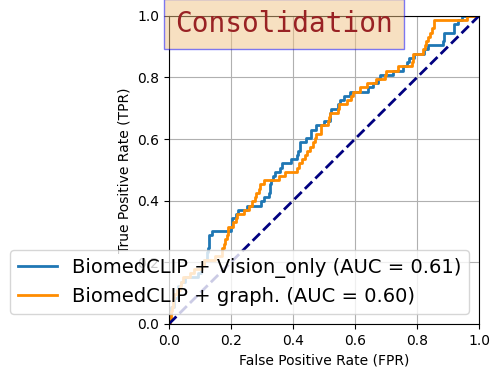

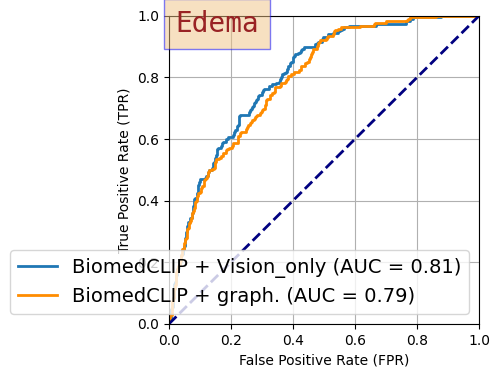

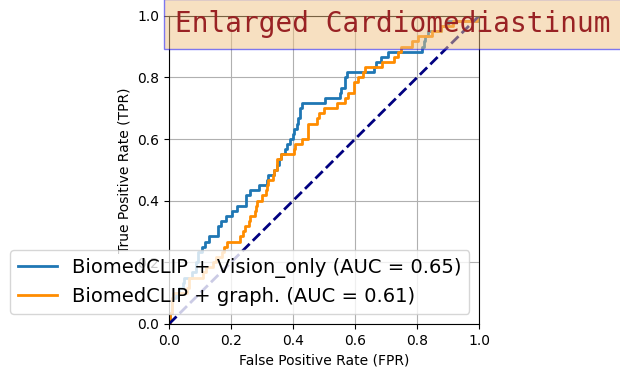

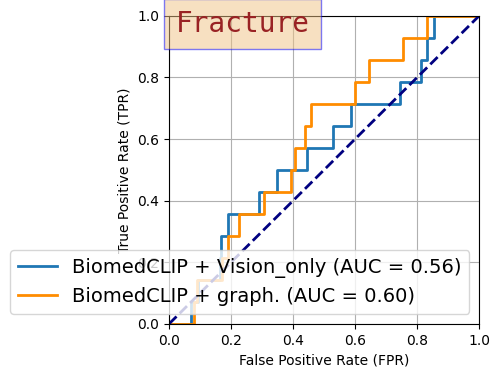

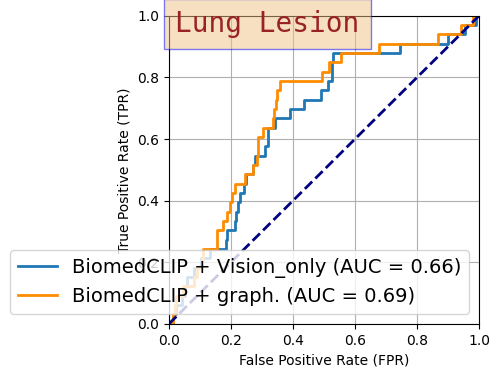

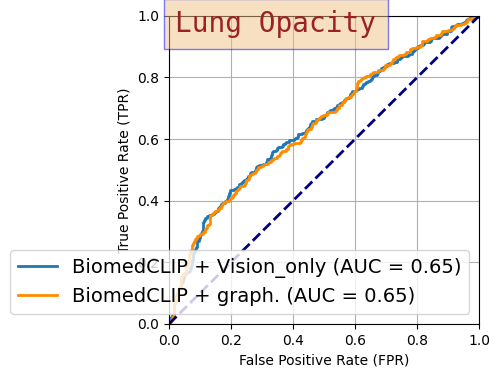

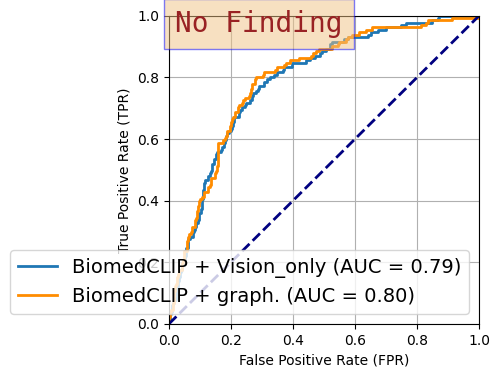

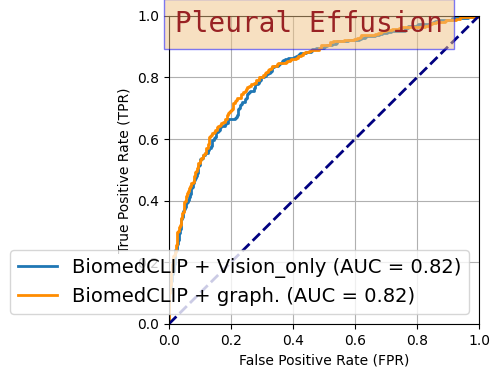

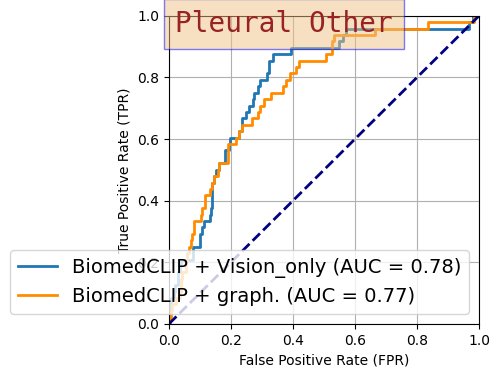

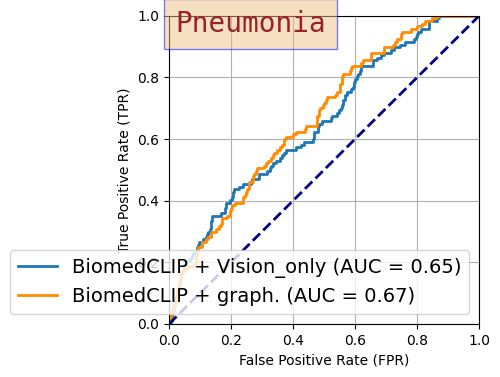

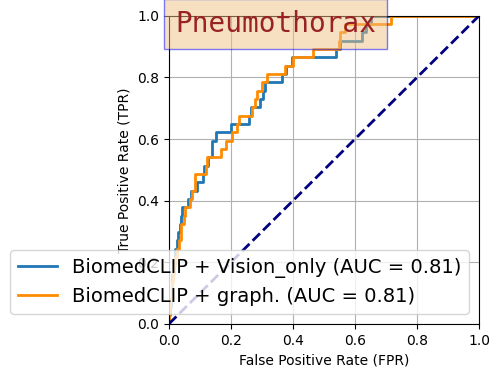

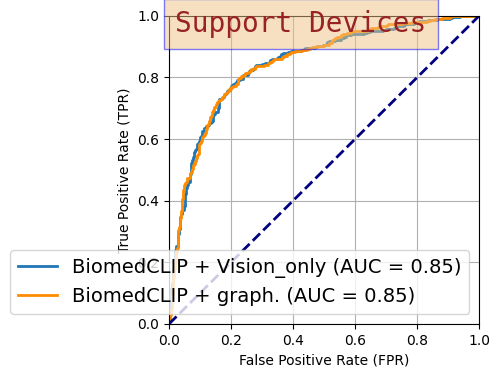

14
auc diff:  -0.030539265053223907
average diff:  -0.002181376075230279


In [48]:
data = { "BiomedCLIP + graph.":{'predict': bio_high_no_ortho_task["predictions"], 'labels':bio_high_no_ortho_task["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
_,_, diff = print_roc(
          data = data , box = True, plot=True)
print(len(diff))
print("auc diff: ", sum(diff)) #"the diff = sum(auc(BiomedCLIP + Vision_only)) - sum(auc(BiomedCLIP + Orth. + Graph))"
print("average diff: ", sum(diff)/len(diff))

<font type=Sylfaen color=#C3A060>using graph can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055>
graph - vision_only = 3 </font><br>

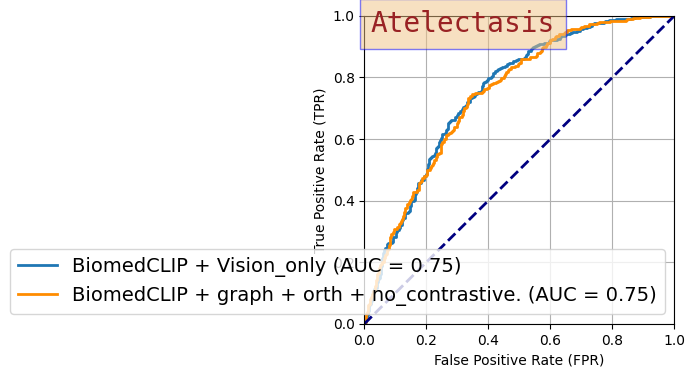

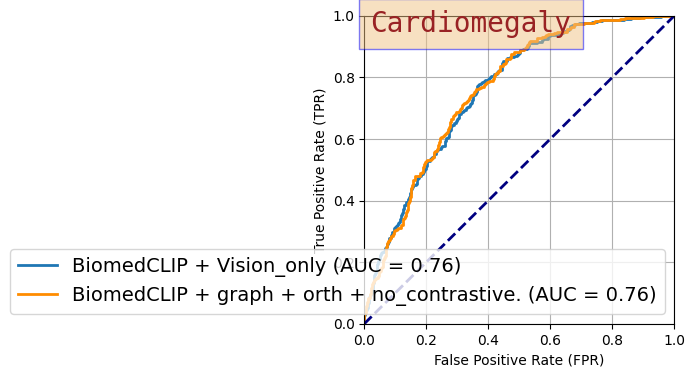

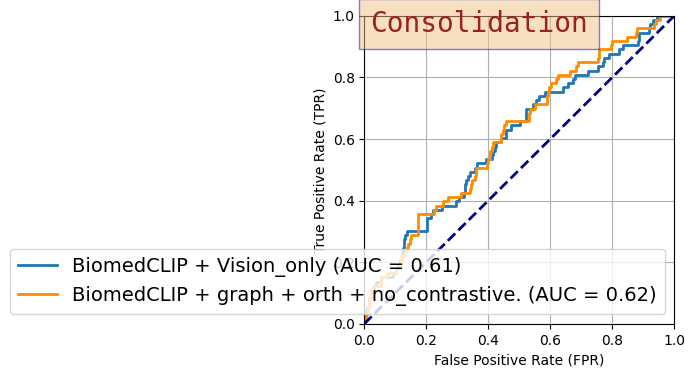

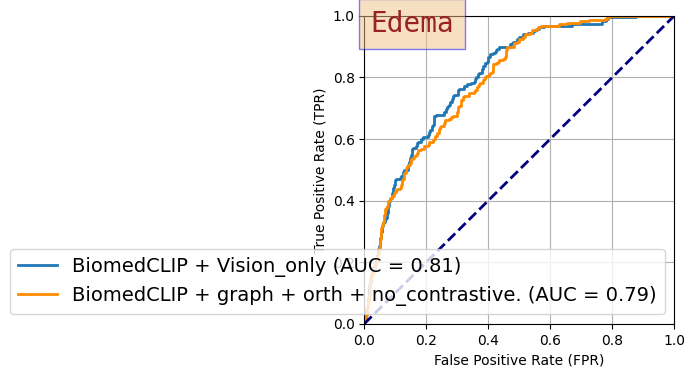

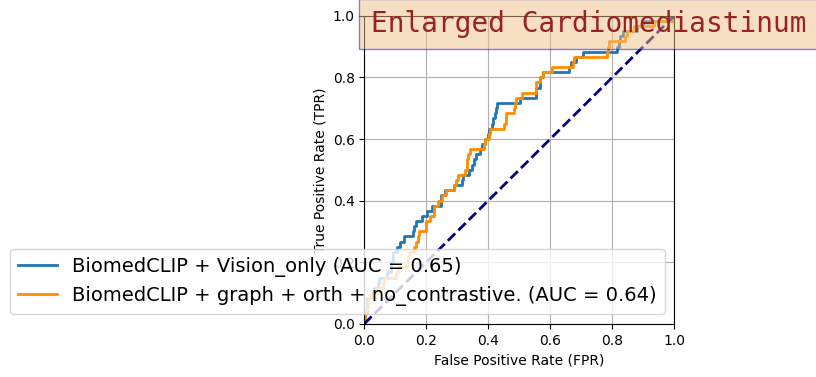

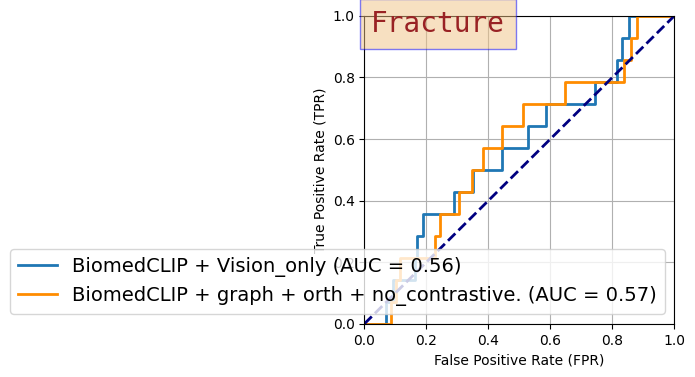

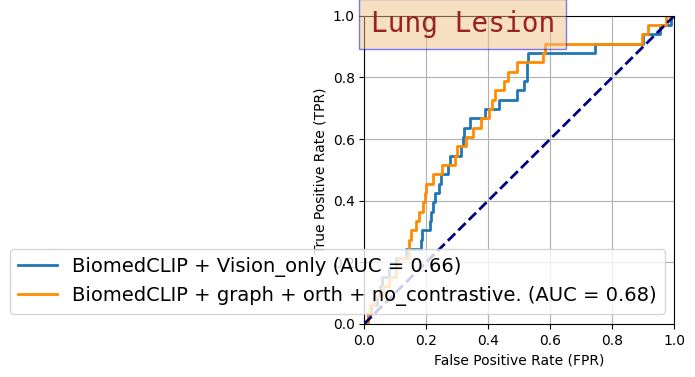

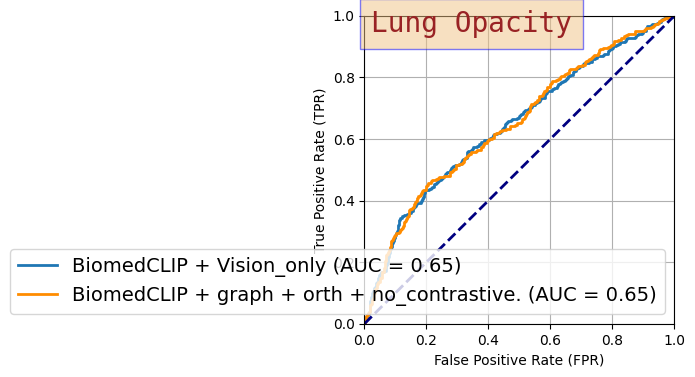

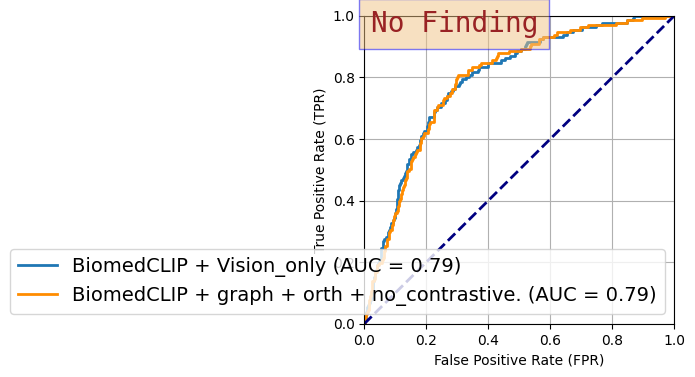

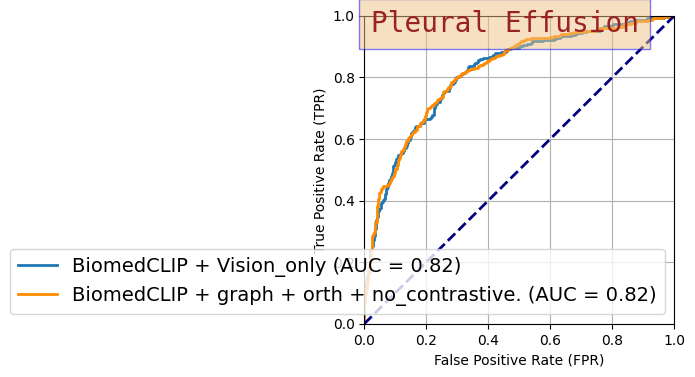

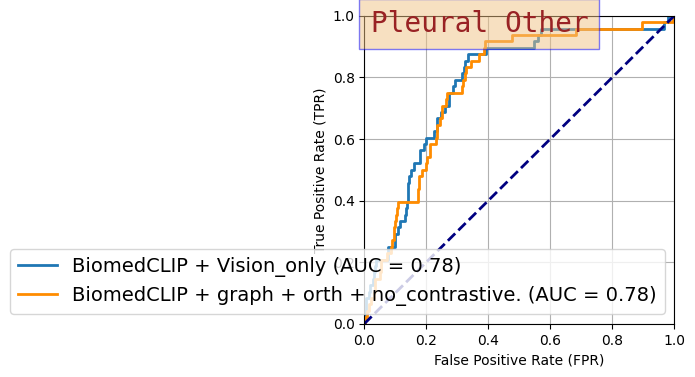

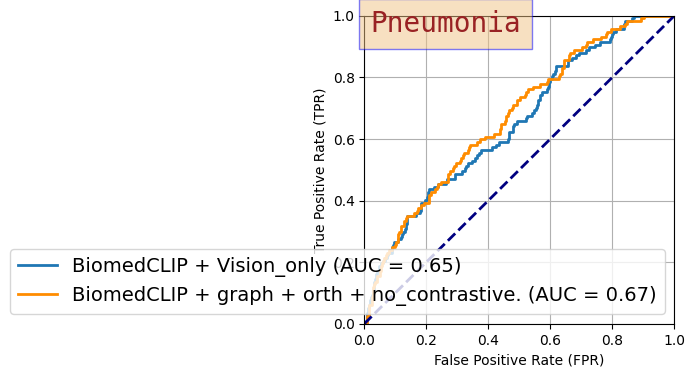

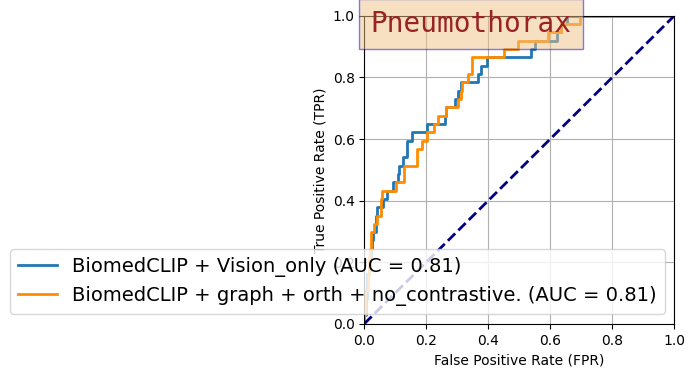

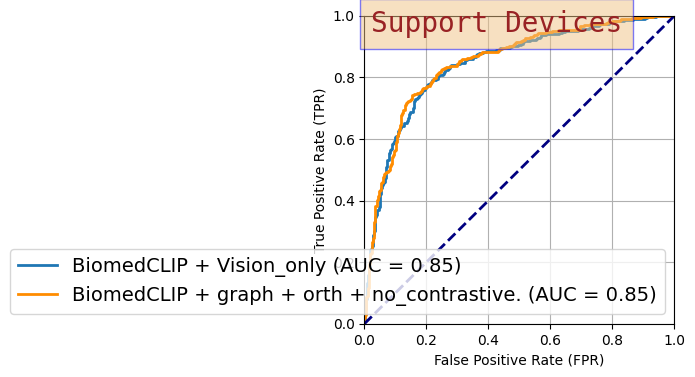

14
auc diff:  -0.033843873582367845
average diff:  -0.0024174195415977034


In [49]:
data = { "BiomedCLIP + graph + orth + no_contrastive.":{'predict': bio_high_no_contrastive_task["predictions"], 'labels':bio_high_no_contrastive_task["labels"]},
        "BiomedCLIP + Vision_only":{"predict":bio_v["predictions"], "labels": bio_v["labels"]}

}
_,_, diff = print_roc(
          data = data , box = True, plot=True)
print(len(diff))
print("auc diff: ", sum(diff)) #"the diff = sum(auc(BiomedCLIP + Vision_only)) - sum(auc(BiomedCLIP + Orth. + Graph))"
print("average diff: ", sum(diff)/len(diff))

<font type=Sylfaen color=#C3A060>using orth + graph + no_contrastive can improve AUC performance compared with the vision only counterpart</font><br>
<font color=#e27055>
(orth + graph + no_contrastive) - vision_only = 3.38 </font><br>

ToDo  
<input type=checkbox> auc comparison between vision_only and graph+orth+NoContrastive configuration 

-----

##### other

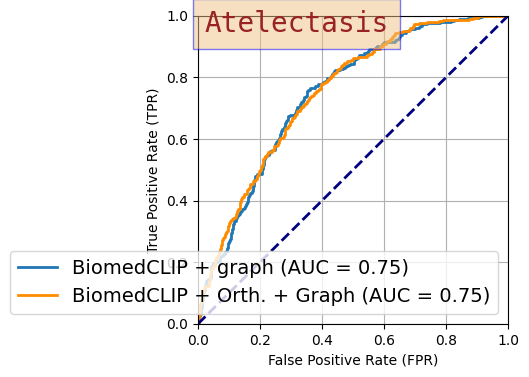

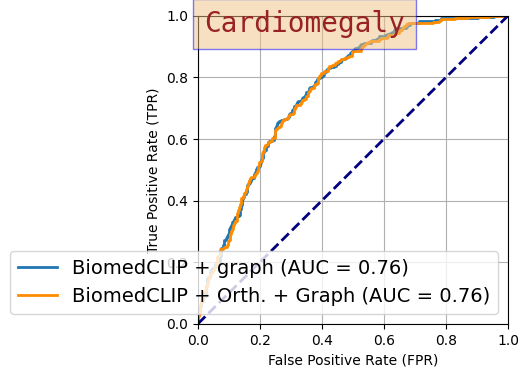

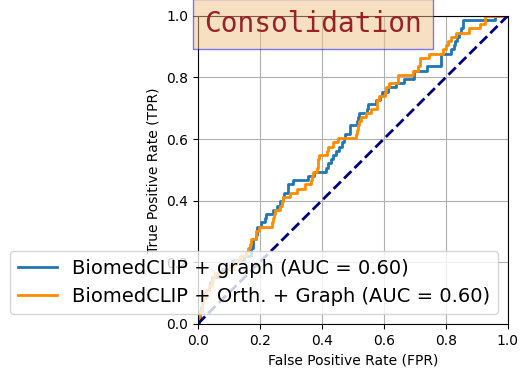

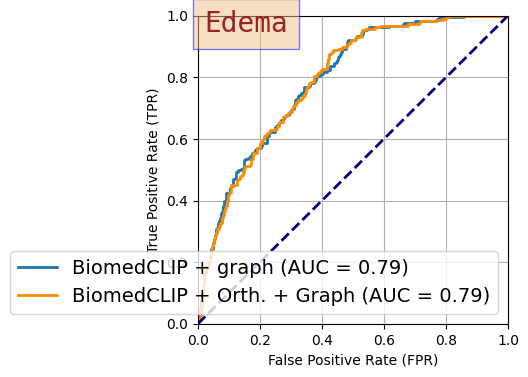

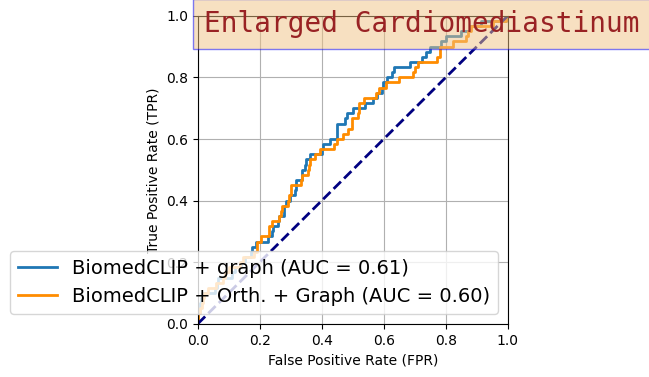

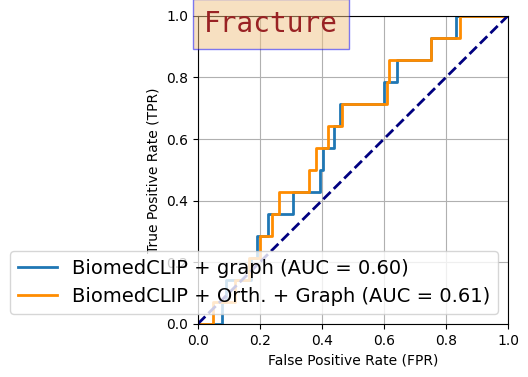

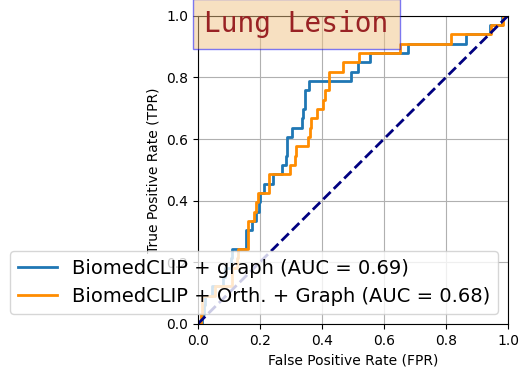

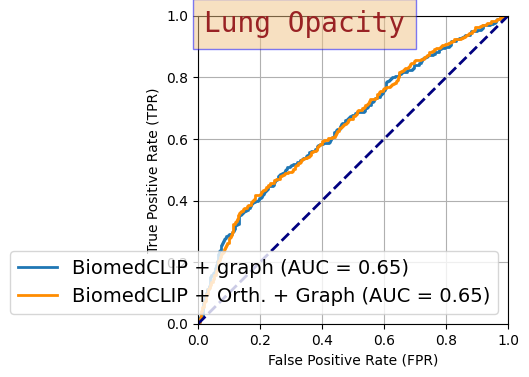

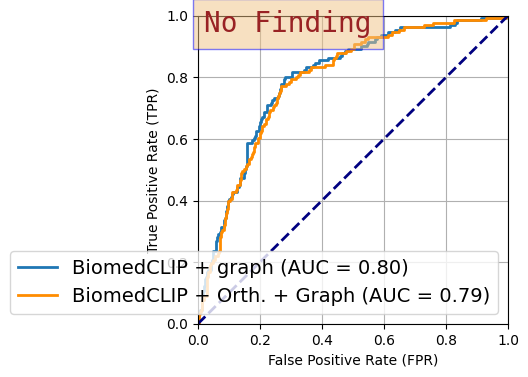

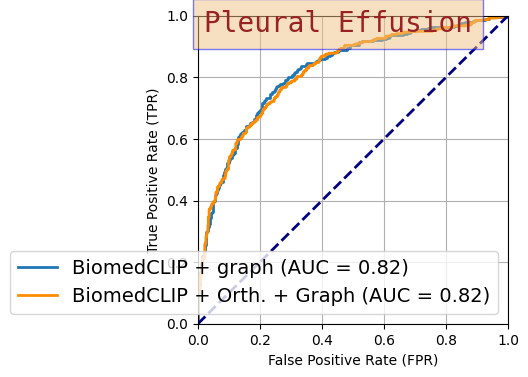

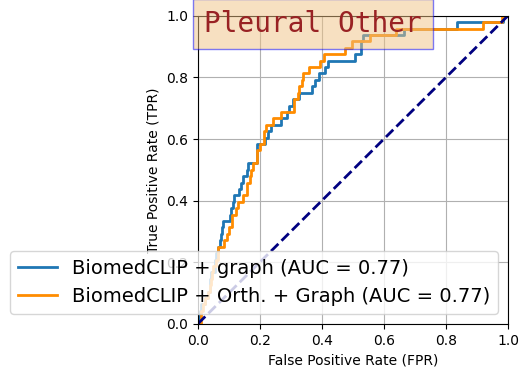

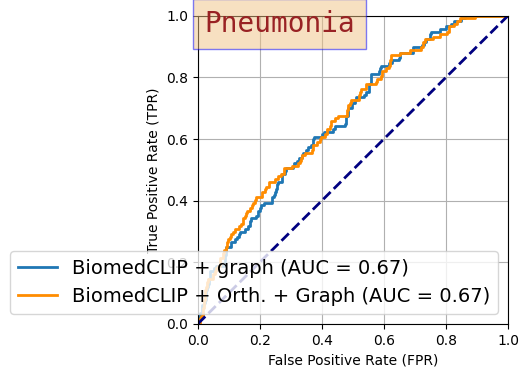

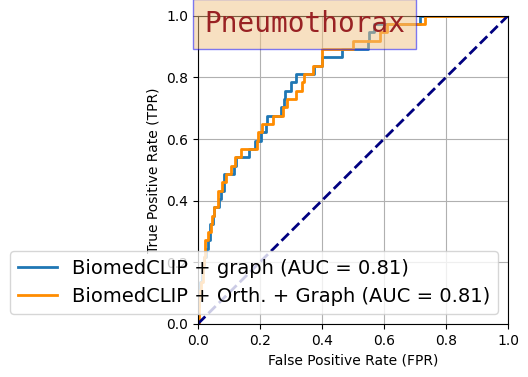

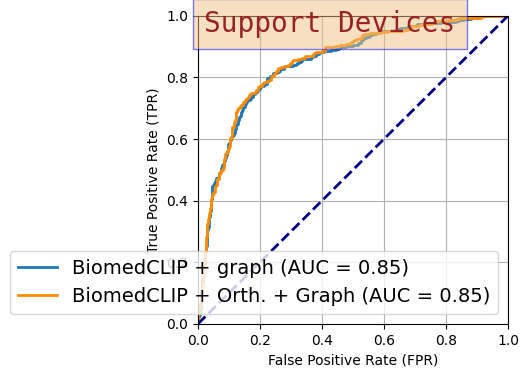

14
auc diff:  0.010989627395888157
average diff:  0.0007849733854205827


In [44]:
data = { "BiomedCLIP + Orth. + Graph":{'predict': bio_high_task["predictions"], 'labels':bio_high_task["labels"]},
        "BiomedCLIP + graph":{"predict":bio_high_no_ortho_task["predictions"], "labels": bio_high_no_ortho_task["labels"]}

}
_,_, diff = print_roc(
          data = data , box = True, plot=True)
print(len(diff))
print("auc diff: ", sum(diff)) #"the diff = sum(auc(BiomedCLIP + Vision_only)) - sum(auc(BiomedCLIP + Orth. + Graph))"
print("average diff: ", sum(diff)/len(diff))

<font color=#e27055>graph without orthogonalization can even slightly better than the graph + orthogonization version</font>

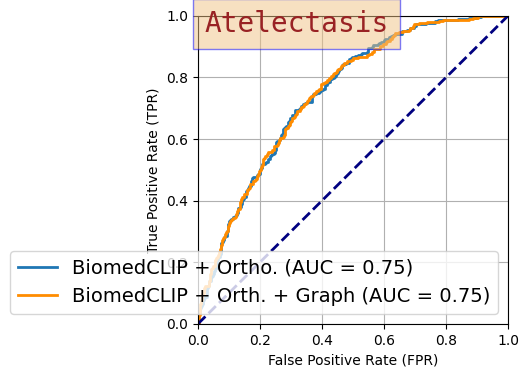

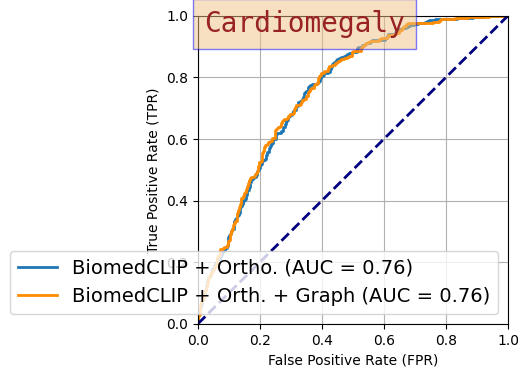

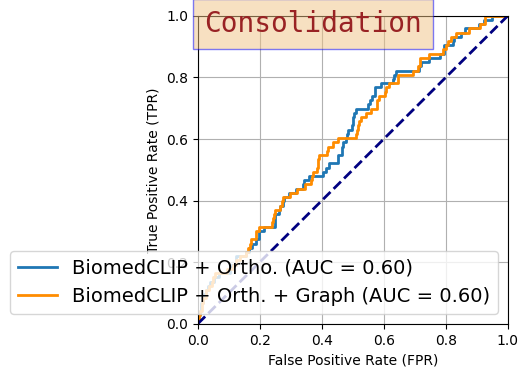

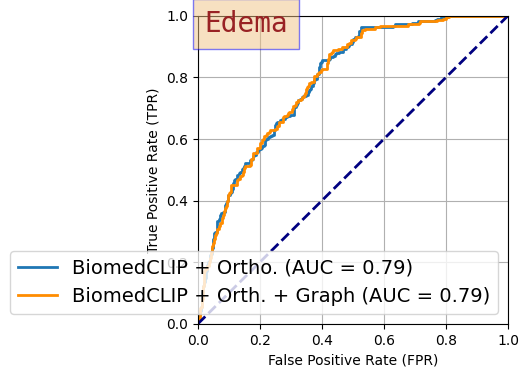

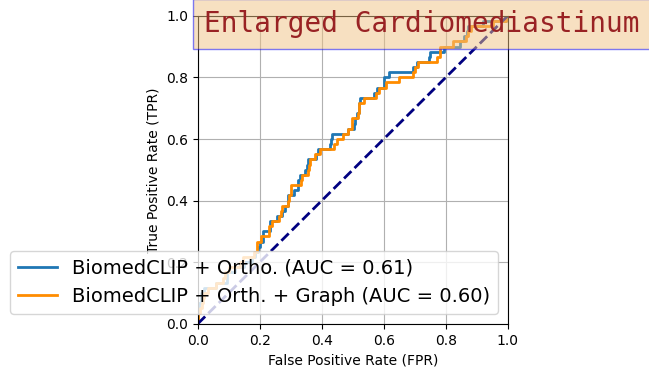

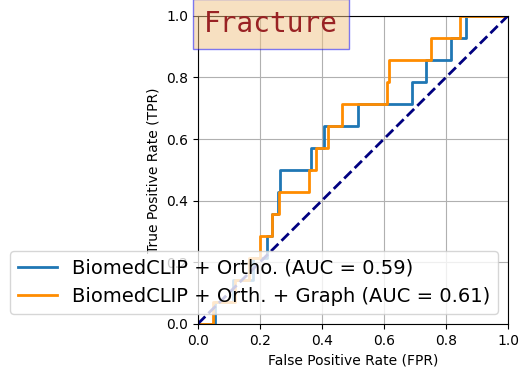

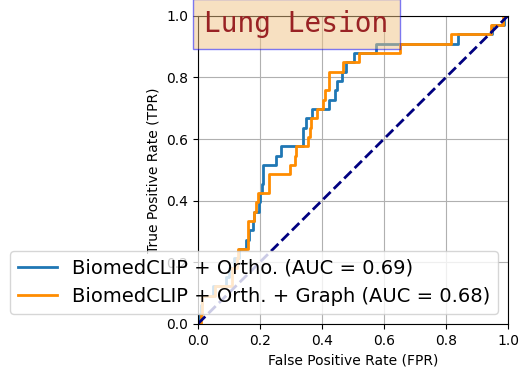

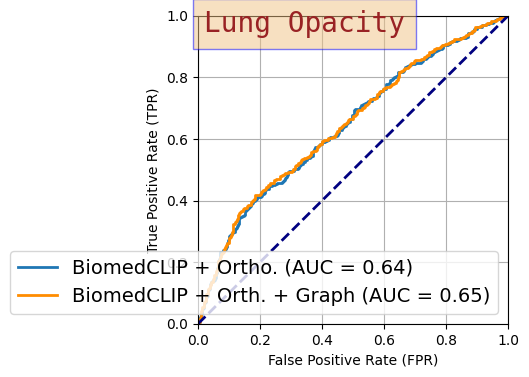

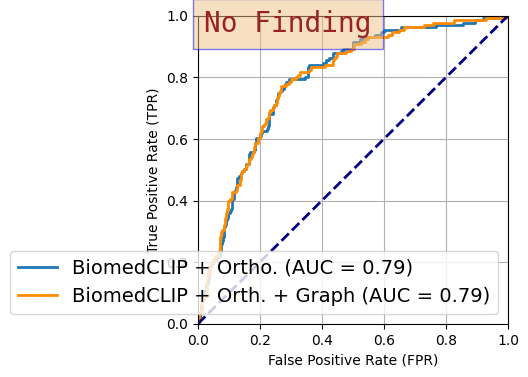

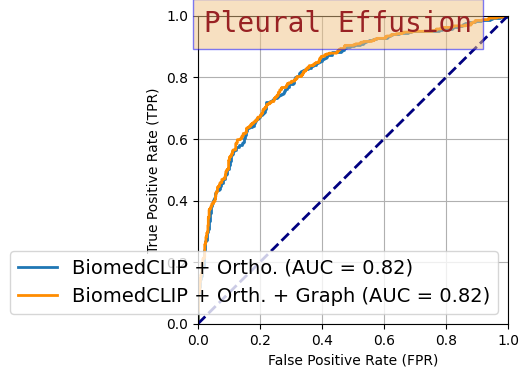

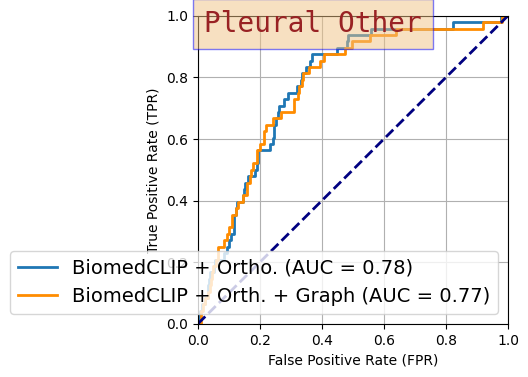

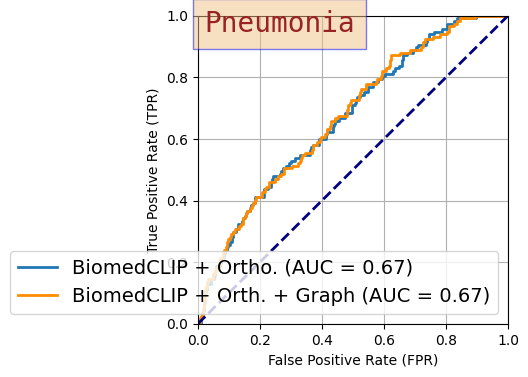

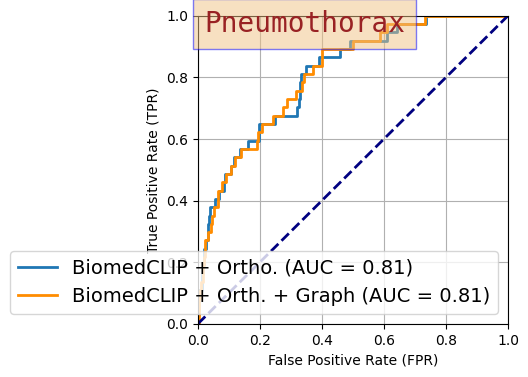

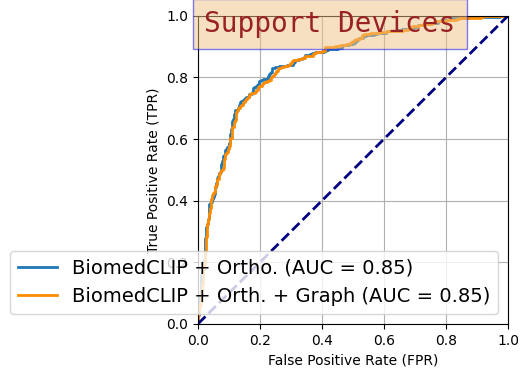

14
auc diff:  -0.009683377575435248
average diff:  -0.0006916698268168034


In [39]:
data = { "BiomedCLIP + Orth. + Graph":{'predict': bio_high_task["predictions"], 'labels':bio_high_task["labels"]},
        "BiomedCLIP + Ortho.":{"predict":bio_orth_task["predictions"], "labels": bio_orth_task["labels"]}

}
_,_, diff = print_roc(
          data = data , box = True, plot=True)
print(len(diff))
print("auc diff: ", sum(diff)) #"the diff = sum(auc(BiomedCLIP + Vision_only)) - sum(auc(BiomedCLIP + Orth. + Graph))"
print("average diff: ", sum(diff)/len(diff))

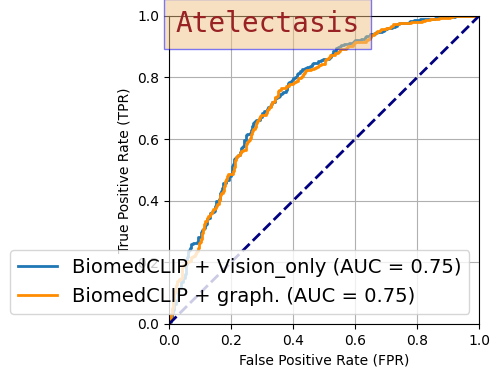

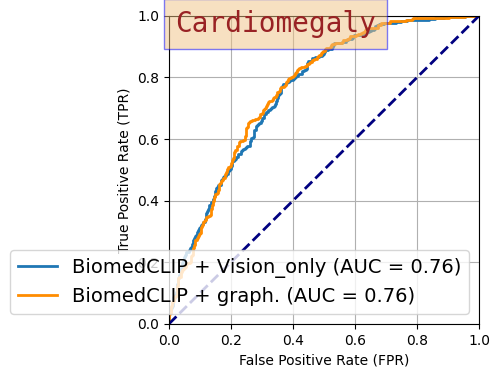

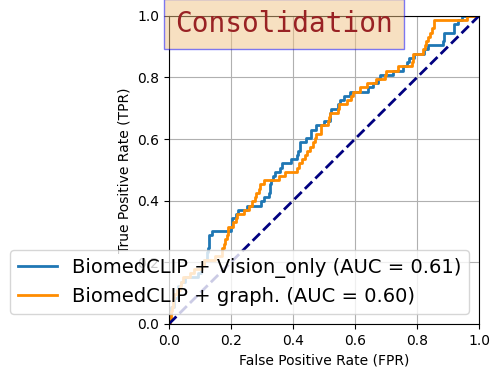

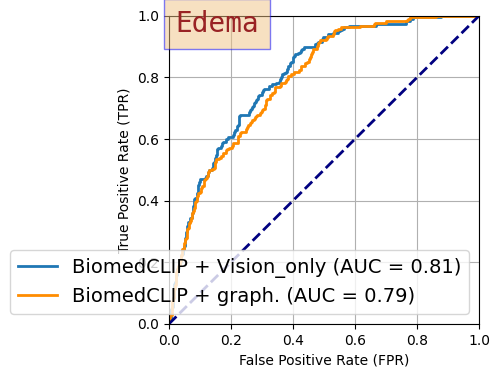

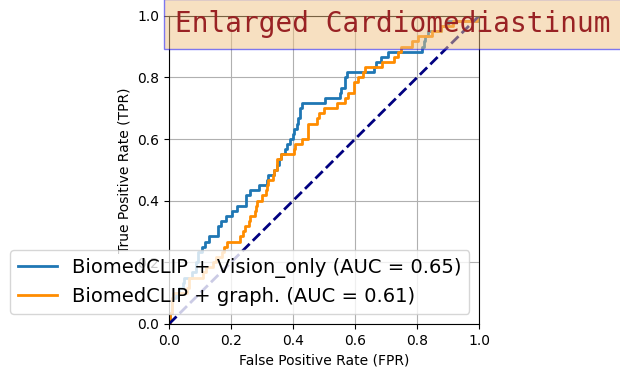

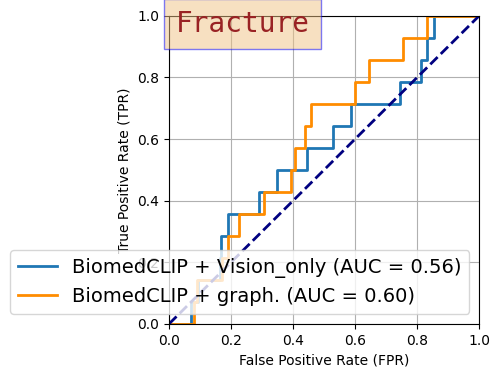

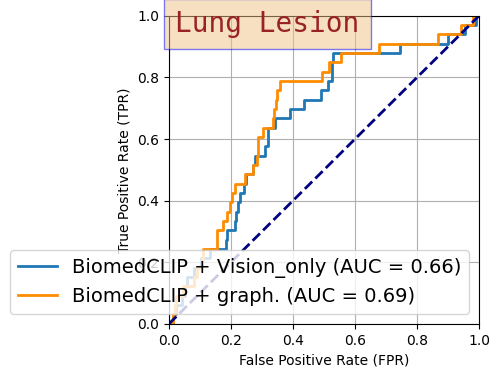

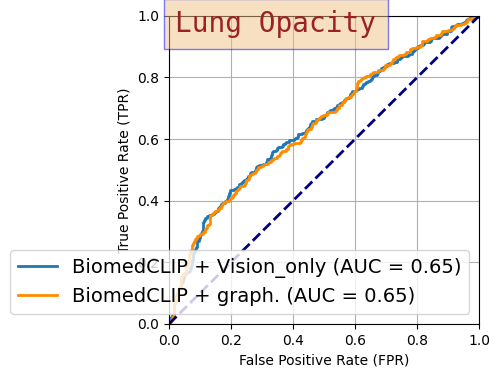

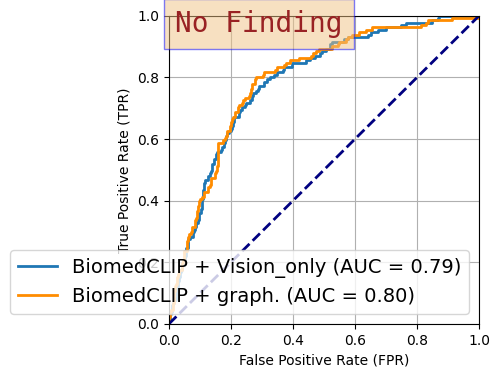

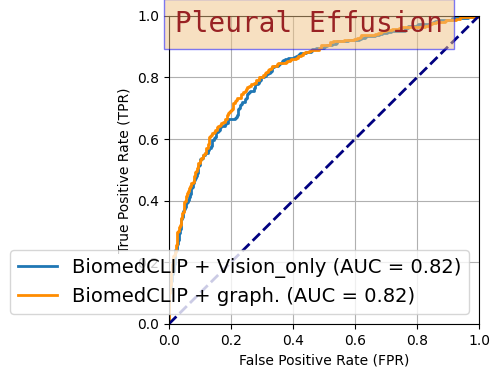

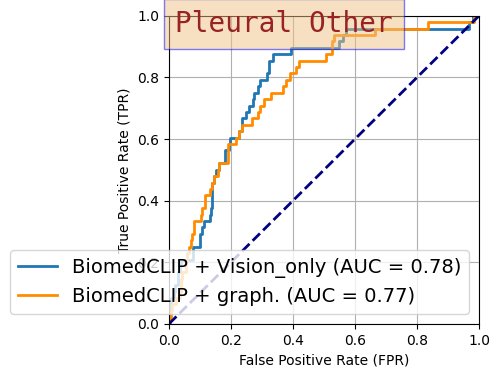

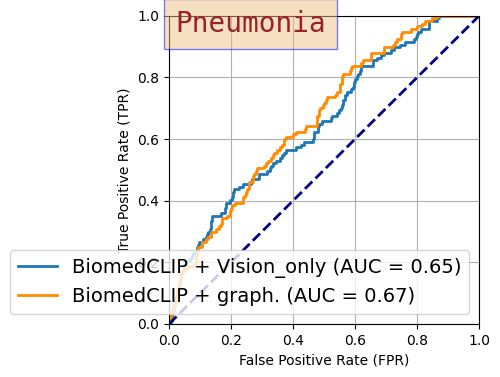

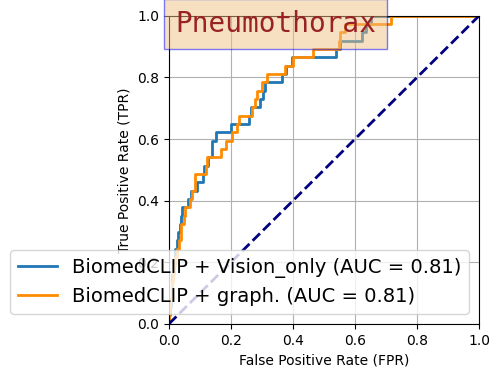

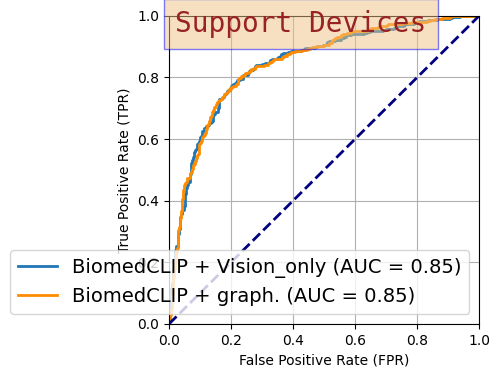

14
auc diff:  -0.030539265053223907
average diff:  -0.002181376075230279


<>